In [19]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt

In [37]:
# Codes for outlier range calculation using IQR and 

def calc_outlier_ranges_IQR(data, axis=None, decrease_lower_range_by=None, increase_upper_range_by=None):
    """
    calculate lower and upper range of outlier detection using IQR method.

    :param data: An array or list. Flattened array or list is preferred. If not flattened, adjust axis argument or
                 preprocess data before giving ito this function.
    :param axis: Axis or axes along which the percentiles are computed. Default set to None for flattened array or list.
    :param decrease_lower_range_by: A user-defined value to decrease lower range of outlier detection.
                                    Default set to None.
    :param increase_upper_range_by: A user-defined value to increase upper range of outlier detection.
                                    Default set to None.

    :return: lower_range, upper_range values of outlier detection.
    """
    q1 = np.nanpercentile(data, 25, axis=axis)
    median = np.nanpercentile(data, 50, axis=axis)
    q3 = np.nanpercentile(data, 75, axis=axis)

    iqr = q3 - q1

    lower_range = np.nanmin([i for i in data if i >= (q1 - 1.5 * iqr)])
    upper_range = np.nanmax([i for i in data if i <= (q3 + 1.5 * iqr)])

    # adjusts lower and upper values by an author-defined range
    if (decrease_lower_range_by is not None) | (increase_upper_range_by is not None):
        if (decrease_lower_range_by is not None) & (increase_upper_range_by is None):
            lower_range = lower_range - decrease_lower_range_by

        elif (increase_upper_range_by is not None) & (decrease_lower_range_by is None):
            upper_range = upper_range + increase_upper_range_by

        elif (increase_upper_range_by is not None) & (decrease_lower_range_by is not None):
            lower_range = lower_range - decrease_lower_range_by
            upper_range = upper_range + increase_upper_range_by

    return lower_range, upper_range, median


def calc_outlier_ranges_MAD(data, axis=None, threshold=3):
    """
    calculate lower and upper range of outlier detection using Median Absolute Deviation (MAD) method.

    A good paper on MAD-based outlier detection:
    https://www.sciencedirect.com/science/article/pii/S0022103113000668

    :param data: An array or list. Flattened array or list is preferred. If not flattened, adjust axis argument or
                 preprocess data before giving ito this function.
    :param axis: Axis or axes along which the percentiles are computed. Default set to None for flattened array or list.
    :param threshold: Value of threshold to use in MAD method.

    :return: lower_range, upper_range values of outlier detection.
    """
    # Calculate the median along the specified axis
    median = np.nanmedian(data, axis=axis)

    # Calculate the absolute deviations from the median
    abs_deviation = np.abs(data - median)

    # Calculate the median of the absolute deviations
    MAD = np.nanmedian(abs_deviation, axis=axis)

    lower_range = median - threshold * MAD
    upper_range = median + threshold * MAD

    return lower_range, upper_range, median

# Loading SW Use Data for 2015

In [48]:
wateruse_2015_df = gpd.read_file('../../Data_main/USGS_water_use_data/WestUS_county_WaterUse_2015.shp') 

print(len(wateruse_2015_df))
wateruse_2015_df.head()

1062


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,fips,...,IC-WSWFr,IC-WFrTo,irr_pixels,irr_gw,irr_sw,irr_tot,sw_pix,sw_pix_2,irrSWfinal,geometry
0,53,009,01531341,0500000US53009,53009,Clallam,06,4503162162,2413868443,53009,...,5.53,5.89,1.0,100.925833,1550.332930,1651.258763,1550.332930,5.851932,5.851932,"MULTIPOLYGON (((-124.60221 48.38693, -124.6003..."
1,53,031,01531936,0500000US53031,53031,Jefferson,06,4671590207,995036034,53031,...,0.13,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.94347 48.12291, -122.9294..."
2,53,027,01531823,0500000US53027,53027,Grays Harbor,06,4924421612,834689898,53027,...,2.19,6.48,1.0,1202.699507,613.965482,1816.664989,613.965482,5.851932,5.851932,"MULTIPOLYGON (((-123.88453 46.96579, -123.8771..."
3,53,049,01513274,0500000US53049,53049,Pacific,06,2415872165,760845729,53049,...,1.28,2.03,2.0,105.131076,179.423703,284.554778,89.711851,5.851932,11.703863,"POLYGON ((-124.09834 46.79407, -124.08165 46.7..."
4,41,007,01135846,0500000US41007,41007,Clatsop,06,2144880465,661621020,41007,...,0.50,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-123.59892 46.25145, -123.5984..."


## Histogram, Boxplot, and Scatterplot

of county-level surfacewater use ('irr_sw') value

In [49]:
# plotting irrgation surfacewater use
irr_sw = [i for i in wateruse_2015_df['irr_sw'].tolist() if ~np.isnan(i)]
print(irr_sw[0:10], '\n')
print('length of non null values of SW use', len(irr_sw))

[1550.3329304642477, 613.9654824080835, 179.42370262154046, 174.2172112508261, 235.16653523286794, 405.35244581226686, 454.3998718735627, 377.53737426615794, 922.5251897484477, 620.4007785603478] 

length of non null values of SW use 279


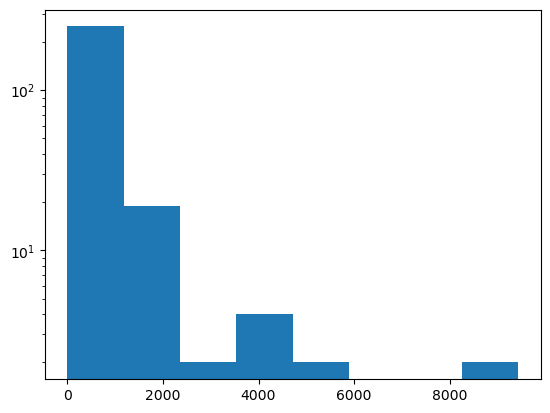

In [50]:
plt.hist(irr_sw, bins=8)
plt.yscale('log')

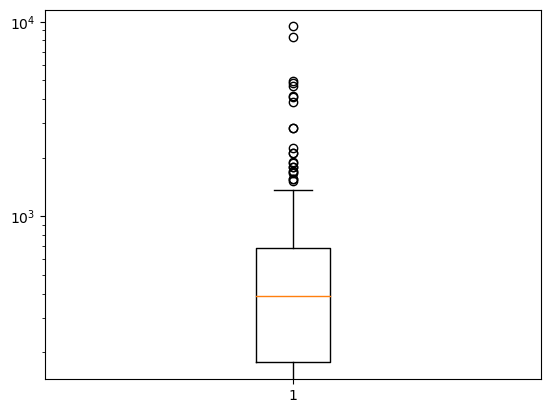

In [51]:
plt.boxplot(irr_sw)
plt.yscale('log')

Text(0.5, 0, 'no. observations')

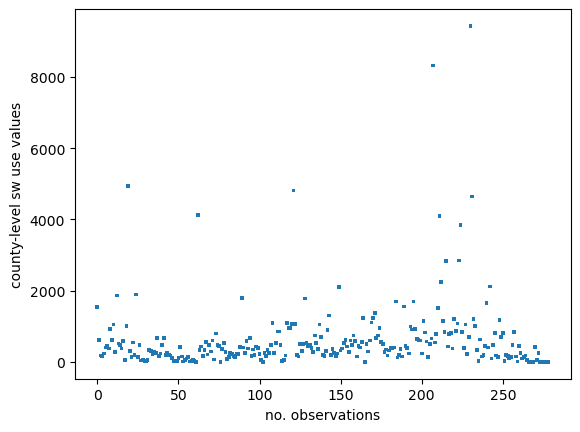

In [53]:
plt.scatter(x=range(len(irr_sw)), y=irr_sw, s= 7, marker=",", edgecolor='none')
# plt.yscale('log')
plt.ylabel('county-level sw use values')
plt.xlabel('no. observations')

Looks like the dataset of county-level surface water use has a positive skew. This means the higher values are outlier. The scatterplot confirms that.

__Process to remove outlier:__
The outliers are difficult to remove as 'irr_sw' is not our final per pixel sw use product. Further outlier might be created if such values of 'irr_sw' exists in counties  where number of irrigated pixels are also low, because that will create high values of SW use per pixel ('sw_pix'). So, we will first calculate SW use per pixel ('sw_pix') and remove outlier using these values. The outlier removed product is 'sw_pix_2' where outlier have been imputed by median values. But the 'sw_pix_2' considers that the sw use value of a country is equally distributed in all sw-irrigated pixels. In our methodology, we will not assume equal distribution, rather total SW use of a county will be distributed based on crop ET percentage in each pixel. Therefore, the 'sw_pix_2' is not the final sw distribution product rather a value created by removing outliers. We will multiply 'sw_pix_2' with the 'number of sw irrigated pixels' to recreate a outlier removed version of sw irrigation in a county 'irrSWfinal'. The 'irrSWfinal' value will be later distributed using crop ET percentage per pixel. 

The code to perform this outlier removal is available at 'Codes/hydro_process_dist/sw_dist.oy' script. 

In [54]:
# Lowest-highest values
lowest_sw_pix = np.min(wateruse_2015_df['sw_pix'])
highest_sw_pix = np.max(wateruse_2015_df['sw_pix'])
print(f'Lowest value: {lowest_sw_pix}, highest value: {highest_sw_pix} (with outliers)', '\n')

# Outlier range by IQR method
low_range_iqr, high_range_iqr, median_iqr = calc_outlier_ranges_IQR(data=wateruse_2015_df['sw_pix'], axis=None, 
                                                                   decrease_lower_range_by=None, increase_upper_range_by=None)

print(f'IQR method lower range: {low_range_iqr}, median: {median_iqr}, upper range: {high_range_iqr}', '\n')

# Outlier range by MAD method
low_range_mad, high_range_mad, median_mad = calc_outlier_ranges_MAD(data=wateruse_2015_df['sw_pix'], axis=None)
print(f'MAD method lower range: {low_range_mad}, median: {median_mad}, upper range: {high_range_mad}', '\n')


Lowest value: 0.0, highest value: 9430.958369044718 (with outliers) 

IQR method lower range: 0.0, median: 5.851931677144091, upper range: 74.23422071353447 

MAD method lower range: -10.817238439851344, median: 5.851931677144091, upper range: 22.521101794139526 



From median value and hydrologic judgement (looking into the total sw use and number of sw-irrigated pixels in a county), the upper range of outlier detection in IQR method is too high.  Therefore, we used upper range from MAD method for outlier detection.

In [69]:
# Finding the total sw irrigation value for a county that corresponds upper range of 'sw_pix' from outlier analysis

wateruse_2015_df_filtered = wateruse_2015_df[(wateruse_2015_df['sw_pix'] >= 22) & (wateruse_2015_df['sw_pix'] <= 23)]
wateruse_2015_df_filtered

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,fips,...,IC-WSWFr,IC-WFrTo,irr_pixels,irr_gw,irr_sw,irr_tot,sw_pix,sw_pix_2,irrSWfinal,geometry
88,41,027,01155131,0500000US41027,41027,Hood River,06,1352203431,29040464,41027,...,49.05,49.52,25.0,5.270571,550.045788,555.316360,22.001832,22.001832,550.045788,"POLYGON ((-121.92203 45.64916, -121.90827 45.6..."
127,32,015,00863368,0500000US32015,32015,Lander,06,14219341092,76104322,32015,...,8.09,119.95,10.0,3135.989902,226.802774,3362.792676,22.680277,5.851932,58.519317,"POLYGON ((-117.80679 39.14538, -117.80385 39.1..."
328,35,061,00933052,0500000US35061,35061,Valencia,06,2762854208,2760092,35061,...,121.46,130.11,39.0,62.180089,873.109091,935.289181,22.387413,22.387413,873.109091,"POLYGON ((-107.20333 34.78303, -107.20331 34.7..."
432,35,037,00929110,0500000US35037,35037,Quay,06,7443334354,18728804,35037,...,32.15,39.21,20.0,98.963386,450.661878,549.625264,22.533094,5.851932,117.038634,"POLYGON ((-104.12922 34.87093, -104.12902 34.9..."
490,08,125,00198178,0500000US08125,08125,Yuma,06,6123763482,11134666,8125,...,1.31,322.78,4.0,22530.991282,91.814473,22622.805755,22.953618,5.851932,23.407727,"POLYGON ((-102.80364 40.00255, -102.79331 40.0..."


The total sw irrigation value for a county that corresponds upper range of 'sw_pix' from outlier analysis is near __450__.

In [58]:
# Finding the corresponding total sw irrigation value is a county

wateruse_2015_df = wateruse_2015_df[22 <= wateruse_2015_df['sw_pix'] <= 23] 

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'fips', 'area', 'COUNTY', 'STATE', 'Year',
       'IC-WGWFr', 'IC-WSWFr', 'IC-WFrTo', 'irr_pixels', 'irr_gw', 'irr_sw',
       'irr_tot', 'sw_pix', 'sw_pix_2', 'irrSWfinal', 'geometry'],
      dtype='object')

Text(0.5, 0, 'no. observations')

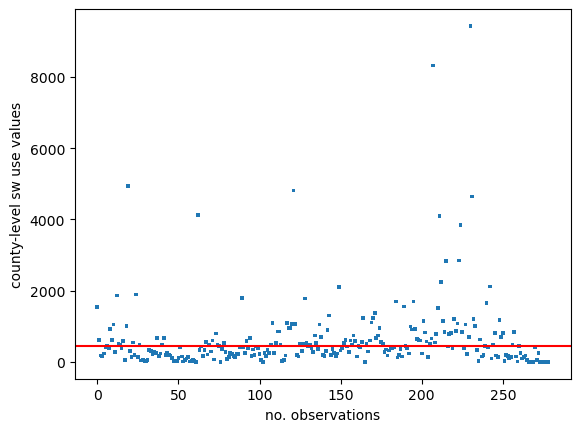

In [66]:
plt.scatter(x=range(len(irr_sw)), y=irr_sw, s= 7, marker=",", edgecolor='none')
# plt.yscale('log')
plt.axhline(y=450, color='r', linestyle='-')
plt.ylabel('county-level sw use values')
plt.xlabel('no. observations')

The values over __450__ are outliers from multivariate outlier analysis using a combined variable 'sw_pix' (sw_pix = irr_sw/irr_pixels) from total county-level surface water irrigation and number of surface water irrigated pixels. The column __irrSWfinal__ is outlier removed and imputed column representing total surface water irrigation in counties in year 2015.

Text(0.5, 0, 'no. observations')

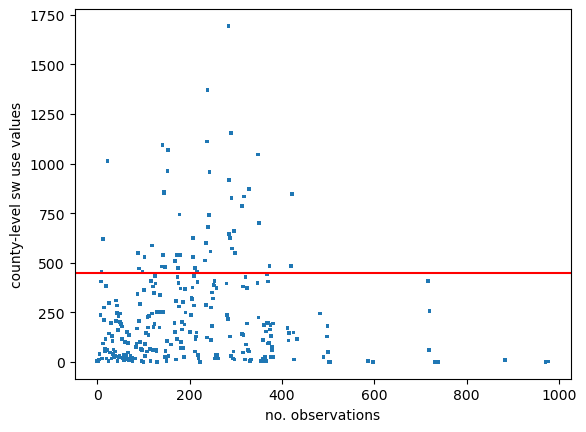

In [67]:
plt.scatter(x=range(len(wateruse_2015_df['irrSWfinal'])), y=wateruse_2015_df['irrSWfinal'], s= 7, marker=",", edgecolor='none')
# plt.yscale('log')
plt.axhline(y=450, color='r', linestyle='-')
plt.ylabel('county-level sw use values')
plt.xlabel('no. observations')

When the finalized-outlier removed yearly total surface water irrigation use of counties are plotted again, some values fall over the outlier detection range (red line). This is Okay. Because we removed outliers based on an attribute that represented per pixel surface water irrigation use, and the red lines filtered out high outliers. But here the values above the red line are not outlier as these counties have many surface water irrigated pixels and per pixel surface water use value is below the outlier detection range __22.52__. 

The following filtered dataframe consists some example of that.

In [68]:
wateruse_2015_df[wateruse_2015_df['irrSWfinal']> 1000]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,fips,...,IC-WSWFr,IC-WFrTo,irr_pixels,irr_gw,irr_sw,irr_tot,sw_pix,sw_pix_2,irrSWfinal,geometry
22,41,029,01135853,0500000US41029,41029,Jackson,06,7208597907,46766412,41029,...,329.29,333.24,91.0,12.169018,1014.464819,1026.633837,11.147965,11.147965,1014.464819,"POLYGON ((-123.23100 42.00493, -123.23097 42.0..."
141,16,087,00399757,0500000US16087,16087,Washington,06,3762870362,53228009,16087,...,331.54,414.43,85.0,273.390270,1093.495117,1366.885387,12.864648,12.864648,1093.495117,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
153,04,027,00023901,0500000US04027,04027,Yuma,06,14281127830,13326079,4027,...,967.86,1075.17,254.0,118.442160,1068.264178,1186.706338,4.205764,4.205764,1068.264178,"POLYGON ((-114.81629 32.50804, -114.81432 32.5..."
237,16,019,00395407,0500000US16019,16019,Bonneville,06,4832871623,88856338,16019,...,578.28,771.04,146.0,370.138195,1110.414584,1480.552779,7.605579,7.605579,1110.414584,"POLYGON ((-112.52003 43.55222, -112.51986 43.6..."
239,16,081,00399297,0500000US16081,16081,Teton,06,1163139950,2868473,16081,...,307.76,404.95,63.0,432.494783,1369.529730,1802.024513,21.738567,21.738567,1369.529730,"POLYGON ((-111.40081 43.85466, -111.40080 43.8..."
284,08,077,00198154,0500000US08077,08077,Mesa,06,8621899288,31440501,8077,...,755.20,755.23,125.0,0.067284,1693.759753,1693.827037,13.550078,13.550078,1693.759753,"POLYGON ((-109.06025 38.59933, -109.05954 38.7..."
290,08,085,00198158,0500000US08085,08085,Montrose,06,5804023559,4923260,8085,...,670.56,670.56,163.0,0.000000,1153.320150,1153.320150,7.075584,7.075584,1153.320150,"POLYGON ((-109.05996 38.49999, -108.60102 38.4..."
348,08,049,00198140,0500000US08049,08049,Grand,06,4782260510,59902381,8049,...,182.83,182.83,49.0,0.000000,1046.047052,1046.047052,21.347899,21.347899,1046.047052,"POLYGON ((-106.65274 40.38897, -106.65219 40.4..."
